# Preparation of Milestone 2

Today we will start to prepare the second milestone. The goals of this milestone are

- Implement an image classification pipeline
    - Implement a Pytorch classification dataset
    - Implement at least two custom augmentations (do not just import one from Torchvision or albumentations)
    - Implement a training and validation loop
    - Optimize your model
    - Evaluate the performance of your model with the F1 score on the test set

### AgNOR-scoring pipeline

To determine the AgNOR-score, we consider the problem an object detection task, where nuclei are discriminated based on the number of identifiable AgNORs. For detection, we used the fully convolutional one-stage object detector (FCOS) by Tian et al. [10], which is a state-of-the-art object detector that does not use anchor boxes like previous approaches and thus comes with a reduced set of hyperparameters to tune. To account for imbalances in the training data, we ensembled five detection models which were trained on five random subsets of the training data. Each of the five models produced its own AgNOR-score by averaging the class labels of all nuclei detected in one image. We used the median to aggregate the results of the ensemble of models per image. During training, we oversampled classes with lower support because of the class imbalance present in the training data. For the same reason, we used a small patch size of 128 × 128 pixels for training since this gave us better control over the classes present on each patch. All models were trained until convergence as observed by the validation loss with a learning rate of 10−4 and Adam as optimizer. To ensure comparability between the results of the study and those of the algorithm, the inference of the detectors was performed analogously to the annotation of the experts described before. The respective image was divided into the same 12 fields, which needed to be processed in the same order as in the study until at least 100 nuclei were detected and classified.

# Pytorch Classification Dataset 

To train neural networks in pytorch with custom datasets, custom dataset classes are needed. Today we will work on a dataset for the term project. A general introduction to custom datasets can be found [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).



Your dataset must have several properties that are specific to the task:

1. Since you only have a small number of images, you will need to use image augmentation. Image augmentation is always applied on the fly. **Never apply image augmentation to images and save the augmented versions to disk for sampling!** Normally, you can use the image augmentation implemented in albumentations or torchvision. **For this project, you will need to implement two augmentations yourself**. I would suggest implementing an augmentation that applies a Gaussian blur to the image and a function that applies a color jitter to the image. Implement the augmentations in a way that they can be **composed** with other TorchVision transformations.

2. Apply minority class oversampling and majority class undersampling for better generalization. You can either implement an initialization function in your dataset where you first sample the coordinates for this epoch, or sample the coordinates on the fly in the __getitem__ method.

3. Your dataset class will inherit from torch.utils.data.Dataset. But you must override the **__len__** and **__getitem__** functions.

## Imports 

In [1]:
import torch
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms, Resize
from torchvision.models import efficientnet_b0
from tqdm import tqdm
from torchmetrics import Accuracy
import torch.nn as nn
# from torcheval.metrics.functional import multiclass_f1_score

# Pytorch Classification Dataset Class

In [2]:
class AgNORDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # returns the number of samples in our dataset.
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = ToTensor()(Image.open(img_path))
        image = Image.open(img_path).convert("RGB")
        filename, max_x, max_y, min_x, min_y, label = self.img_labels.iloc[idx]
        image = image.crop((min_x,min_y,max_x,max_y))
        # cropped_image = image[min_x:min_y, max_x:max_y]

        # Gaussian blur
        # color jitter
        

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

## Image Augmentation Class

In [3]:
class GaussianBlur(object):
    def __init__(self, radius=1):
        self.radius = radius

    def __call__(self, img):
        if random.random() < 0.5:
            return img
        else:
            return img.filter(ImageFilter.GaussianBlur(radius=self.radius))

class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, img):
        transforms = []
        if self.brightness > 0:
            brightness_factor = random.uniform(max(0, 1 - self.brightness), 1 + self.brightness)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if self.contrast > 0:
            contrast_factor = random.uniform(max(0, 1 - self.contrast), 1 + self.contrast)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if self.saturation > 0:
            saturation_factor = random.uniform(max(0, 1 - self.saturation), 1 + self.saturation)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if self.hue > 0:
            hue_factor = random.uniform(-self.hue, self.hue)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = torchvision.transforms.Compose(transforms)
        return transform(img)

# Loading our Dataset

In [4]:
transform = transforms.Compose([
    Resize((224, 224)),  # the pretrained model will expect images to be all fixed size
    ToTensor()
])            
dataset = AgNORDataset(annotations_file='annotation_frame.csv',
                       img_dir='Dataset',
                       transform=transform,
                       target_transform=None)

# dataset.__getitem__(0)

# Iterating and Visualizing a sample of the Dataset

you have to set the <span style="font-size: bigger;">**transfrom=False**</span> for the visualization purpouses beacause of the size of the transforation

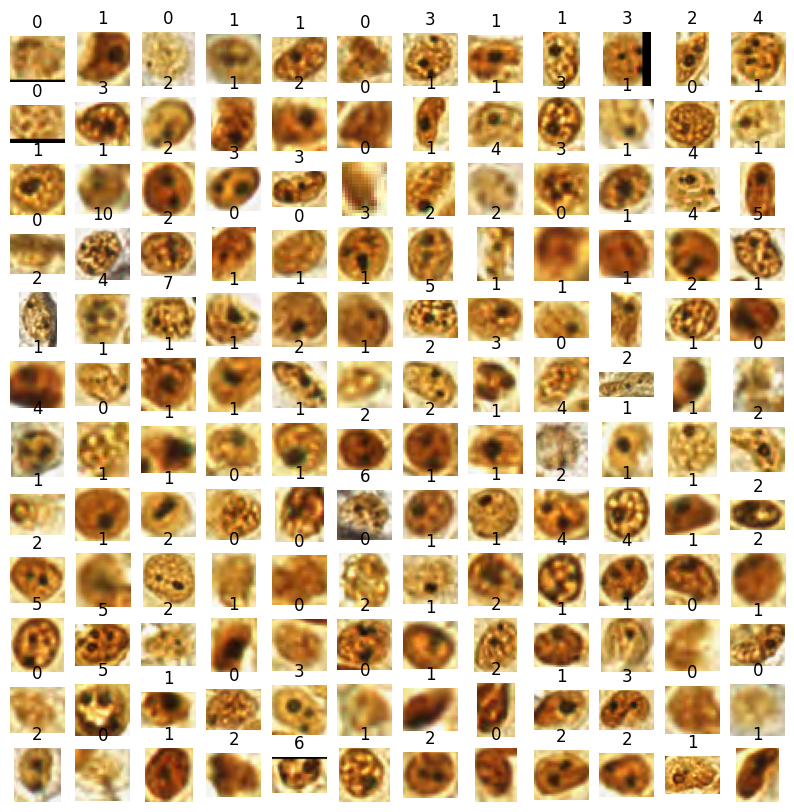

In [5]:
labels_map = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]
dataset.transform = False

figure = plt.figure(figsize=(10, 10))
cols, rows = 12, 12
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
    img, label = dataset.__getitem__(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img)
    
plt.show()

In [6]:
dataset.transform = transform

# Training/Validation/Test Split

After you have successfully created your dataset, you need to define a training, validation, and test split of the data. Split the images at the image level! Splits must not overlap!

1. Split the data.
2. Initialize a dataset for each split and pass it to a Pytorch dataloader.

In [7]:
train_size = int(0.7 * dataset.__len__())
eval_size = int(0.15 * dataset.__len__())
test_size = dataset.__len__() - train_size - eval_size

train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

# Initliazie a classification model from pytorch.

For classification we will use a pre-trained model from pytorch. I would suggest an efficientnet_b0. Since we do not have too much training data and to mitigate overfitting, we will use ImageNet weights and only train the last layer. We will also freeze most of the network since we do not have much data and to save training time.

1. Load the model from torchvision (see[https://pytorch.org/vision/stable/models.html]).
2. Load the respective weights.
3. Freeze all but the last layer. If you have a gpu available, bring your model to the gpu.

In [8]:
weights = 'IMAGENET1K_V1' 
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(1280,12)

# print(f'{name} --> {param.requires_grad}')
# model.features.requires_grad == False
# model.features.children
for name, param in model.named_parameters():
    param.requires_grad = False
    # print(name, param.requires_grad)
for name, param in model.classifier.named_parameters():
    param.requires_grad = True
    # print(name, param.requires_grad)
# model.classifier

In [9]:
# # from torchvision.models import ResNet50_Weights
# import torchvision

# # weights = ResNet50_Weights.DEFAULT
# model = torchvision.models.resnet50(weights='DEFAULT')

# # model.eval()


# # Freeze all but the last layer
# for name, param in model.named_parameters():
#     param.requires_grad = False
#     # print(name, param.requires_grad)
# # Set requires_grad=True only for the parameters of the last layer
# for name, param in model.fc.named_parameters():
#     param.requires_grad = True
#     # print(name, param.requires_grad)


<span style="font-size: 16px;">print the last layer which will be used for backprop</span>

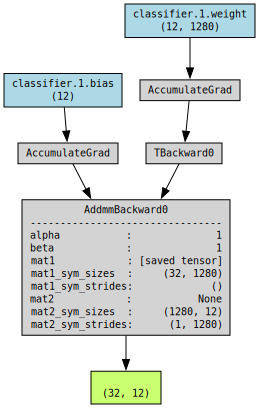

In [10]:
from torchviz import make_dot
dummy_input = torch.randn(32, 3, 3, 3)
output = model(dummy_input)
make_dot(output, params=dict(model.named_parameters()),show_attrs=True)

# Optimization Loop

a) The next step is the actual model optimization. But before we implement the training and validation loops, we need to initialize a loss function and an optimizer. We can use Adam as the optimizer and Cross Entropy Loss as the loss function from pytorch. We also need to set a learning rate for the model optimization.

1. Initialize a Loss Function
2. Initializing an Optimizer and Setting a Learning Rate


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
num_classes = 12
task = 'MULTICLASS'
device = torch.device("mps")
model.to(device)
metric=Accuracy(task=task,num_classes=num_classes).to(device)

b) Now, we will implement an optimization loop. First we implement the training phase. Implement a function (**train_one_epoch**) which performs the follwing steps.:

1. Define a variable running_loss in which you can store the change in loss during training. Since we will later chain the function with a validation function, bring the model to training mode if needed.
2. Iterate over your train dataloader, in each epoch you must:
    1. Transfer the tensors with the images and labels to the GPU or CPU, depending on the device on which your model is located.
    2. Delete the old gradients in the optimizer.
    3. Perform the actual forward pass, i.e. pass the images to the model and calculate the predictions (model(imgs))
    4. Calculate the loss
    5. Backpropagate the loss (loss.backward())
    6. Perform the optimization step (optimizer.stepp())
    7. Add the loss of the current batch to your running_loss
    8. Print the loss every x batches, also return the average loss of the epoch

**Tip:** use **[tqdm.notebook.tqdm](https://tqdm.github.io/docs/notebook/)** to visualize the progress during the epoch.

In [12]:
def train_one_epoch(model, train_loader, loss_fn, device):
    model = model.to(device)
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training iteration")):
        images, labels = images.to(device), labels.to(device)
        # model.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch_idx % 10 == 9: #  Print the loss every 10 batches
            avg_loss = running_loss / 10
            print(f'Batch {batch_idx + 1}/{len(train_loader)}, Loss: {avg_loss:.4f}')
            running_loss = 0.0

    avg_loss = running_loss / len(train_loader)
    
    return avg_loss

In [13]:
# train_one_epoch(
#     model=model,
#     train_loader=train_loader,
#     loss_fn=loss_fn,
#     device=device
# )

c) We also need a validation loop, which is called after a training loop to determine the training progress on the validation data. Implement this in a function (**validate_one_epoch**). This loop looks very similar to the training loop, but we can skip the backpropagation here. Also, use a metric from Torchmetrics to measure the performance of your models. The validation function should also return the loss or the metric so you can use it to select the best model during training.

1. Turn off gradient storage. Put your model in evaluation mode. Since there is no backpropagation in the validation, we do not need it and can save a lot of memory.
2. As with the training loop, iterate over the validation data loader and perform a forward pass in each epoch.
3. Compute a loss in each epoch, but not backpropagated
4. Store and output the loss and return the average loss of the epoch
5. Update your metric with the predictions and labels of each batch
6. Calculate your metric after the last batch.


In [14]:
def validate_one_epoch(model, eval_loader, loss_fn, metric, device):
    model = model.to(device)
    model.eval()
    metric.reset()
    
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(eval_loader, desc="Validation iteration"):
            images, labels = images.to(device), labels.to(device)
    

            outputs = model(images)
    
            loss = loss_fn(outputs, labels)
    
            running_loss += loss.item()

            metric(outputs, labels)

    
    
        avg_loss = running_loss / len(train_loader)

        metric_result = metric.compute()
    
    return avg_loss, metric_result

In [15]:
# validate_one_epoch(
#     model=model,
#     eval_loader=eval_loader,
#     loss_fn=loss_fn,
#     metric=metric,
#     device=device
# )

d) Combine training and validation in an optimization loop. This loop is run **n_epochs** times. In each iteration, first call your training function and then your validation function. In each epoch, check to see if your model has improved, and if so, save the model. Do not save a new checkpoint in each epoch, as this will consume too much memory. Save the losses of the training and validation functions over the epochs to plot them at the end of your training. If you do not have a GPU available, you do not need to train your model to convergence. Just train a few steps.

In [16]:
def optimization_loop(model, train_loader, val_loader, loss_fn, optimizer, metric, device, n_epochs, model_save_path=None):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    # device=('cpu')
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")

        # Training 
        train_loss = train_one_epoch(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation 
        val_loss, metric_result = validate_one_epoch(model, eval_loader, loss_fn, metric, device)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
            if model_save_path:
                torch.save(model.state_dict(), model_save_path)
                print("Model saved.")

    plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

In [17]:
model_save_path = 'best_model.pth'
n_epochs=10

In [ ]:
optimization_loop(model, 
                  train_loader, 
                  eval_loader, 
                  loss_fn, 
                  optimizer, 
                  device=device,
                  metric=metric, 
                  n_epochs=n_epochs, 
                  model_save_path=model_save_path) # Path to save the BEST model

Epoch 1/10


Training iteration:   2%|▌                     | 10/432 [00:06<03:45,  1.87it/s]

Batch 10/432, Loss: 2.0239


Training iteration:   5%|█                     | 20/432 [00:11<03:33,  1.93it/s]

Batch 20/432, Loss: 1.5833


Training iteration:   7%|█▌                    | 30/432 [00:16<03:28,  1.93it/s]

Batch 30/432, Loss: 1.4649


Training iteration:   9%|██                    | 40/432 [00:22<03:44,  1.75it/s]

Batch 40/432, Loss: 1.5050


Training iteration:  12%|██▌                   | 50/432 [00:27<03:22,  1.88it/s]

Batch 50/432, Loss: 1.4129


Training iteration:  14%|███                   | 60/432 [00:32<03:16,  1.90it/s]

Batch 60/432, Loss: 1.3800


Training iteration:  16%|███▌                  | 70/432 [00:38<03:08,  1.92it/s]

Batch 70/432, Loss: 1.3039


Training iteration:  19%|████                  | 80/432 [00:43<03:01,  1.94it/s]

Batch 80/432, Loss: 1.3206


Training iteration:  21%|████▌                 | 90/432 [00:48<02:58,  1.92it/s]

Batch 90/432, Loss: 1.3806


Training iteration:  23%|████▊                | 100/432 [00:53<02:53,  1.92it/s]

Batch 100/432, Loss: 1.2858


Training iteration:  25%|█████▎               | 110/432 [00:59<02:54,  1.85it/s]

Batch 110/432, Loss: 1.3608


Training iteration:  28%|█████▊               | 120/432 [01:05<03:03,  1.70it/s]

Batch 120/432, Loss: 1.2198


Training iteration:  30%|██████▎              | 130/432 [01:11<03:32,  1.42it/s]

Batch 130/432, Loss: 1.4201


Training iteration:  32%|██████▊              | 140/432 [01:20<03:41,  1.32it/s]

Batch 140/432, Loss: 1.2626


Training iteration:  35%|███████▎             | 150/432 [01:26<03:02,  1.55it/s]

Batch 150/432, Loss: 1.2507


Training iteration:  37%|███████▊             | 160/432 [01:33<02:45,  1.64it/s]

Batch 160/432, Loss: 1.2615


Training iteration:  39%|████████▎            | 170/432 [01:39<02:33,  1.71it/s]

Batch 170/432, Loss: 1.2232


Training iteration:  42%|████████▊            | 180/432 [01:44<02:24,  1.74it/s]

Batch 180/432, Loss: 1.3033


Training iteration:  44%|█████████▏           | 190/432 [01:50<02:16,  1.77it/s]

Batch 190/432, Loss: 1.2766


Training iteration:  46%|█████████▋           | 200/432 [01:56<02:18,  1.67it/s]

Batch 200/432, Loss: 1.3388


Training iteration:  49%|██████████▏          | 210/432 [02:02<02:07,  1.75it/s]

Batch 210/432, Loss: 1.2857


Training iteration:  51%|██████████▋          | 220/432 [02:07<01:55,  1.84it/s]

Batch 220/432, Loss: 1.2973


Training iteration:  53%|███████████▏         | 230/432 [02:13<01:47,  1.87it/s]

Batch 230/432, Loss: 1.2686


Training iteration:  56%|███████████▋         | 240/432 [02:18<01:41,  1.88it/s]

Batch 240/432, Loss: 1.2768


Training iteration:  58%|████████████▏        | 250/432 [02:24<01:36,  1.89it/s]

Batch 250/432, Loss: 1.2858


Training iteration:  60%|████████████▋        | 260/432 [02:29<01:30,  1.90it/s]

Batch 260/432, Loss: 1.2676


Training iteration:  62%|█████████████▏       | 270/432 [02:34<01:25,  1.90it/s]

Batch 270/432, Loss: 1.2989


Training iteration:  65%|█████████████▌       | 280/432 [02:39<01:19,  1.92it/s]

Batch 280/432, Loss: 1.2308


Training iteration:  67%|██████████████       | 290/432 [02:45<01:14,  1.92it/s]

Batch 290/432, Loss: 1.2732


Training iteration:  69%|██████████████▌      | 300/432 [02:50<01:08,  1.92it/s]

Batch 300/432, Loss: 1.2558


Training iteration:  72%|███████████████      | 310/432 [02:55<01:03,  1.92it/s]

Batch 310/432, Loss: 1.2540


Training iteration:  74%|███████████████▌     | 320/432 [03:00<01:03,  1.76it/s]

Batch 320/432, Loss: 1.2914


Training iteration:  76%|████████████████     | 330/432 [03:06<00:53,  1.90it/s]

Batch 330/432, Loss: 1.2742


Training iteration:  79%|████████████████▌    | 340/432 [03:11<00:49,  1.85it/s]

Batch 340/432, Loss: 1.3011


Training iteration:  81%|█████████████████    | 350/432 [03:16<00:43,  1.91it/s]

Batch 350/432, Loss: 1.1853


Training iteration:  83%|█████████████████▌   | 360/432 [03:21<00:38,  1.88it/s]

Batch 360/432, Loss: 1.1994


Training iteration:  86%|█████████████████▉   | 370/432 [03:27<00:33,  1.88it/s]

Batch 370/432, Loss: 1.1765


Training iteration:  88%|██████████████████▍  | 380/432 [03:32<00:28,  1.85it/s]

Batch 380/432, Loss: 1.2758


Training iteration:  90%|██████████████████▉  | 390/432 [03:38<00:22,  1.88it/s]

Batch 390/432, Loss: 1.2053


Training iteration:  93%|███████████████████▍ | 400/432 [03:43<00:17,  1.87it/s]

Batch 400/432, Loss: 1.1890


Training iteration:  95%|███████████████████▉ | 410/432 [03:48<00:11,  1.88it/s]

Batch 410/432, Loss: 1.3402


Training iteration:  97%|████████████████████▍| 420/432 [03:54<00:07,  1.59it/s]

Batch 420/432, Loss: 1.3179


Training iteration: 100%|████████████████████▉| 430/432 [04:00<00:01,  1.87it/s]

Batch 430/432, Loss: 1.2577


Training iteration: 100%|█████████████████████| 432/432 [04:02<00:00,  1.78it/s]


Train Loss: 0.0049


Validation iteration: 100%|█████████████████████| 93/93 [00:47<00:00,  1.95it/s]


Validation Loss: 0.2547
Model saved.
Epoch 2/10


Training iteration:   2%|▌                     | 10/432 [00:05<03:49,  1.84it/s]

Batch 10/432, Loss: 1.2169


Training iteration:   5%|█                     | 20/432 [00:11<04:00,  1.71it/s]

Batch 20/432, Loss: 1.2451


Training iteration:   7%|█▌                    | 30/432 [00:16<03:37,  1.85it/s]

Batch 30/432, Loss: 1.1141


Training iteration:   9%|██                    | 40/432 [00:22<03:30,  1.86it/s]

Batch 40/432, Loss: 1.1725


Training iteration:  12%|██▌                   | 50/432 [00:27<03:24,  1.87it/s]

Batch 50/432, Loss: 1.1243


Training iteration:  14%|███                   | 60/432 [00:32<03:21,  1.84it/s]

Batch 60/432, Loss: 1.2500


Training iteration:  16%|███▌                  | 70/432 [00:38<03:10,  1.90it/s]

Batch 70/432, Loss: 1.2034


Training iteration:  19%|████                  | 80/432 [00:43<03:09,  1.86it/s]

Batch 80/432, Loss: 1.2016


Training iteration:  21%|████▌                 | 90/432 [00:48<03:00,  1.90it/s]

Batch 90/432, Loss: 1.1984


Training iteration:  23%|████▊                | 100/432 [00:53<02:57,  1.87it/s]

Batch 100/432, Loss: 1.1793


Training iteration:  25%|█████▎               | 110/432 [00:59<02:50,  1.89it/s]

Batch 110/432, Loss: 1.2216


Training iteration:  28%|█████▊               | 120/432 [01:05<03:09,  1.65it/s]

Batch 120/432, Loss: 1.2736


Training iteration:  30%|██████▎              | 130/432 [01:10<02:41,  1.87it/s]

Batch 130/432, Loss: 1.2008


Training iteration:  32%|██████▊              | 140/432 [01:16<02:37,  1.85it/s]

Batch 140/432, Loss: 1.0869


Training iteration:  35%|███████▎             | 150/432 [01:21<02:31,  1.86it/s]

Batch 150/432, Loss: 1.1521


Training iteration:  37%|███████▊             | 160/432 [01:26<02:25,  1.87it/s]

Batch 160/432, Loss: 1.1520


Training iteration:  39%|████████▎            | 170/432 [01:32<02:19,  1.87it/s]

Batch 170/432, Loss: 1.1023


Training iteration:  42%|████████▊            | 180/432 [01:37<02:13,  1.89it/s]

Batch 180/432, Loss: 1.1624


Training iteration:  44%|█████████▏           | 190/432 [01:43<02:15,  1.78it/s]

Batch 190/432, Loss: 1.1689


Training iteration:  46%|█████████▋           | 200/432 [01:48<02:07,  1.82it/s]

Batch 200/432, Loss: 1.1830


Training iteration:  49%|██████████▏          | 210/432 [01:54<02:02,  1.82it/s]

Batch 210/432, Loss: 1.1467


Training iteration:  51%|██████████▋          | 220/432 [01:59<01:58,  1.80it/s]

Batch 220/432, Loss: 1.1346


Training iteration:  53%|███████████▏         | 230/432 [02:05<01:52,  1.79it/s]

Batch 230/432, Loss: 1.2926


Training iteration:  56%|███████████▋         | 240/432 [02:11<01:48,  1.76it/s]

Batch 240/432, Loss: 1.1757


Training iteration:  58%|████████████▏        | 250/432 [02:17<01:57,  1.54it/s]

Batch 250/432, Loss: 1.1294


Training iteration:  60%|████████████▋        | 260/432 [02:23<01:43,  1.65it/s]

Batch 260/432, Loss: 1.1156


Training iteration:  62%|█████████████▏       | 270/432 [02:29<01:35,  1.69it/s]

Batch 270/432, Loss: 1.2388


Training iteration:  65%|█████████████▌       | 280/432 [02:36<01:39,  1.53it/s]

Batch 280/432, Loss: 1.1452


Training iteration:  67%|██████████████       | 290/432 [02:42<01:30,  1.57it/s]

Batch 290/432, Loss: 1.1371


Training iteration:  69%|██████████████▌      | 300/432 [02:48<01:17,  1.69it/s]

Batch 300/432, Loss: 1.1812


Training iteration:  72%|███████████████      | 310/432 [02:54<01:14,  1.63it/s]

Batch 310/432, Loss: 1.2032


Training iteration:  74%|███████████████▌     | 320/432 [03:00<01:08,  1.63it/s]

Batch 320/432, Loss: 1.1914


Training iteration:  74%|███████████████▌     | 321/432 [03:01<01:06,  1.67it/s]

# Model testing

Once the optimization is complete, you can test your model on the test data. This means that you apply your model to the images in your dataset. To do this, iterate over all instances in your test data set.

1. Initialize the best performing model.
2. Initialize the F1 score metric from TorchVision.
3. Iterate over all instances in the test dataset and update your metric after each batch.
4. Compute the final metric.

In [ ]:
from torchmetrics import F1Score

model.load_state_dict(torch.load('best_model.pth'))

f1_score_metric = F1Score(task=task,num_classes=num_classes).to(device)

model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad(): 
        outputs = model(images)

    f1_score_metric(outputs, labels)

final_f1_score = f1_score_metric.compute()

print("Final F1 Score:", final_f1_score)